# Twitter Sentiment Analysis

Hello and welcome to my main notebook.

This notebook is created as part of Flatiron School final project. The goal of this project is to create a model that can predict and automate the sentiment analysis of tweets on behalf of hypothetical company to track people's opinion aboout their company in real time.

There is one other notebook in this repo that can generate the data by exporting tweets directly from twitter API and save it on a csv file.

In [ ]:
#!pip install textblob

In [ ]:
#pip install -U pandas==1.3.4 --user

In [ ]:
#!pip install wordcloud

## Imports

Importing necessary packages

In [29]:
from tweepy import OAuthHandler
import tweepy
import json
import pandas as pd
import numpy as np
import csv
import re
import string
import os
import time


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.optimizers import SGD
from tensorflow.keras import regularizers


import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


## Loading the Data

Below I load the data that was generated in another notebook.

In [5]:
#Loading the data
tweets_raw = pd.read_csv('Data/tweets.csv')

tweets_raw.head()

,id,text,withheld
0,1588380338581307393,Elon Musk took over Twitter. If anyone doesn't...,NaN
1,1588380317601390592,Why is this Twitter buyout a good thing again?...,NaN
2,1588380311271792642,Elon Musk’s Twitter layoffs are starting https...,NaN
3,1588380297212481536,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",NaN
4,1588380273800093697,«An email went out to the company’s employees ...,NaN


The Column "id" and "withheld" can be droped out later.

In [6]:
#check any missing value
tweets_raw.isna().sum()

id              0
text            0
withheld    30332
dtype: int64

# Labeling the Data

Since our data directly coming from twitter, it doesn't have any label(sentiment). So, I need to label with the help of Vader Package.

In [7]:
nltk.download("vader_lexicon")

#Dropping Columns I don't need
tweets_raw.drop(columns=['id','withheld'], axis=1, inplace=True)
tweets_raw.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text
0,Elon Musk took over Twitter. If anyone doesn't...
1,Why is this Twitter buyout a good thing again?...
2,Elon Musk’s Twitter layoffs are starting https...
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek..."
4,«An email went out to the company’s employees ...


In [8]:
#Labeling Data with Vader Analyzer. 
sentiments = SentimentIntensityAnalyzer()
tweets_raw["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in tweets_raw["text"]]
tweets_raw["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in tweets_raw["text"]]
tweets_raw["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in tweets_raw["text"]]
tweets_raw['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in tweets_raw["text"]]
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732


The compound score is what we need to assign a sentiment to each tweet. for this project I decided to give a 'Negative' sentiment to values below -0.05 and 'Poitive' for values above 0.05. The rest should be 'Neutral'

In [9]:
score = tweets_raw["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
tweets_raw["Sentiment"] = sentiment
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000,Neutral
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199,Positive
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000,Neutral
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182,Negative
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732,Negative


In [10]:
# Keeping just relevant columns
tweets_raw = tweets_raw[['text','Sentiment']]

In [12]:
# Counting the total number of each sentiment
tweets_raw['Sentiment'].value_counts()

Negative    12037
Neutral      9377
Positive     8921
Name: Sentiment, dtype: int64

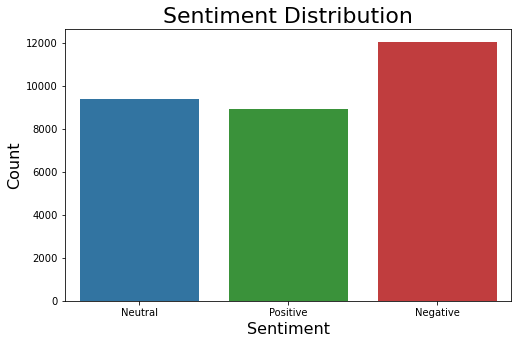

In [16]:
# Plotting the Sentiment distribution
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(tweets_raw['Sentiment'], palette = ['tab:blue', 'tab:green', 'tab:red'])
ax.set_title('Sentiment Distribution', fontsize=22)
ax.set_xlabel('Sentiment', fontsize=16)
ax.set_ylabel('Count', fontsize=16);

# Pre-Processing

In this section I will define some function for data cleaning and data visualizations

In [17]:
#Downloading the Stop Words
Stop_Words = stopwords.words('english')
Stop_Words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
nltk.download('wordnet')
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Cleaning

In the block below, I defined a function to clean the the data from #hashtags, URL's, @mentions, numbers, and punctuations.
Then I removed the stop words and used lemmitizer to get the root of the words and finally join them as a sentence.
I repeat this section for every tweet by iterating over each tweet by list comprehensive.

It should be noted that, I created extended version of stop words to remove the words without any sentiment for better results. These words were added after some analysis later on this notebook.

This function will also give you an option to choose from stemmer/lemmitizer.

In [20]:
def Cleaning_tweets(df):
    '''
    This function will Clean the given dataframe from any URL's, Mentions, Hashtags, Punctuations, Numbers,etc.
    and also lemmitize the words and returns a dataframe with cleaned tweet as a new column.
    
    '''  
    stemmer = PorterStemmer()
    s_stemmer = nltk.stem.SnowballStemmer(language="english")
    lemmatizer = WordNetLemmatizer()
    
    Extended_Stop_Words = stopwords.words('english')
    Extended_Stop_Words.extend(['elon','musk','twitter'])
    
    def clean_tweet(tweet):
        if type(tweet) == np.float:
            return ""
        temp = tweet.lower() # lower case the text
        temp = re.sub("'", "", temp) # to avoid removing contractions in english
        temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
        temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
        temp = re.sub('[0-9]+', '', temp)
        temp = re.sub(r'http\S+', '', temp) # removes URL's
        temp = re.sub('[()!?]', ' ', temp) # removes special charecters
        temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
        temp = re.sub("[^a-z0-9]"," ", temp)
        temp = temp.split() # splitting the words
#        temp = [s_stemmer.stem(w) for w in temp if not w in Stop_Words] # Removes the stop words and Stemming
        
#        temp = [(word, get_wordnet_pos(word)) for word in temp if not word in Stop_Words]
        temp = [lemmatizer.lemmatize(w) for w in temp if not w in Extended_Stop_Words] # Removes the stop words and Lemming
        temp = " ".join(word for word in temp) # join all words together
        return temp
    results = [clean_tweet(tw) for tw in list(df.text)] # iterete over each tweet and clean it based on above function
    df['Cleaned_Text'] = results
    return df 

In [21]:
#Cleaning the tweets based on function above
Cleaning_tweets(tweets_raw)

,text,Sentiment,Cleaned_Text
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,took anyone doesnt want leave dont let door hi...
1,Why is this Twitter buyout a good thing again?...,Positive,buyout good thing also always resting smug fac...
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,layoff starting
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,shocked
4,«An email went out to the company’s employees ...,Negative,email went company employee late thursday noti...
...,...,...,...
30330,'No choice': Elon Musk justifies mass layoffs ...,Negative,choice justifies mass layoff
30331,Here's why Binance's CZ invested in Twitter fo...,Neutral,here binances cz invested following acquisitio...
30332,Elon Musk says Twitter had ‘no choice’ over th...,Neutral,say choice thousand layoff company losing per day
30333,Thousands of staff at social media company Twi...,Neutral,thousand staff social medium company job new o...


In the couple blocks below, I checked the original tweet and cleaned version to see if my function is working as I want. 

In [25]:
#Cleaned tweet
tweets_raw.Cleaned_Text.iloc[4]

'email went company employee late thursday notifying employee plan cut job informing pacific time friday worker would receive email subject line role'

In [26]:
#Original tweet
tweets_raw.text.iloc[4]

'«An email went out to the company’s employees late Thursday notifying employees of plans to cut jobs, informing them that by 9 a.m. Pacific time Friday, workers would receive an email with the subject line: “Your Role at Twitter.”» #Twitter #ChiefTwit  https://t.co/ypfkN5mHjS'

# Visuallization

In this section I tried to see the most frequent words in each sentiment and find some relationships between the words and sentiment, which will be used for some visualizations.

In [32]:
#this function is the exact same function as cleaning tweets but instead of giving a sentence, It givees us the words
def Tokenizing_tweets(df):
    '''
    This function will Clean the given dataframe from any URL's, Mentions, Hashtags, Punctuations, Numbers,etc.
    and also lemmitize the words and returns a dataframe with cleaned tweet as a new column.
    
    '''  

    Extended_Stop_Words = stopwords.words('english')
    Extended_Stop_Words.extend(['elon','musk','twitter'])
    def clean_tweet(tweet):
        if type(tweet) == np.float:
            return ""
        temp = tweet.lower() # lower case the text
        temp = re.sub("'", "", temp) # to avoid removing contractions in english
        temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
        temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
        temp = re.sub(r'http\S+', '', temp) # removes URL's
        temp = re.sub('[()!?]', ' ', temp) # removes special charecters
        temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
        temp = re.sub("[^a-z0-9]"," ", temp)
        temp = temp.split() # splitting the words
        temp = [w for w in temp if not w in Extended_Stop_Words] # Removes the stop words and Lemming
        return temp
    results = [clean_tweet(tw) for tw in list(df.text)] # iterete over each tweet and clean it based on above function
    df['Tokenized_Text'] = results
    return df 

In [33]:
df = Tokenizing_tweets(tweets_raw)
df.head()

,text,Sentiment,Cleaned_Text,Tokenized_Text
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,took anyone doesnt want leave dont let door hi...,"[took, anyone, doesnt, wants, leave, dont, let..."
1,Why is this Twitter buyout a good thing again?...,Positive,buyout good thing also always resting smug fac...,"[buyout, good, thing, also, always, resting, s..."
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,layoff starting,"[layoffs, starting]"
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,shocked,[shocked]
4,«An email went out to the company’s employees ...,Negative,email went company employee late thursday noti...,"[email, went, company, employees, late, thursd..."


In [35]:
# Defining different variables for each sentiment
Positive_sent = tweets_raw[tweets_raw['Sentiment']=='Positive']
Negative_sent = tweets_raw[tweets_raw['Sentiment']=='Negative']
Neutral_sent = tweets_raw[tweets_raw['Sentiment']=='Neutral']

In [36]:
# Creating function to plot word clouds
def plot_wordcloud(text,mask = None, max_words=2000, max_font_size=50, figure_size=(20,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    
#    mask = np.array(Image.open('/Users/milad/Downloads/twitter-logo.png'))    
#    mask = np.array(Image.open('/Users/milad/Downloads/twitter-logo.png'))
#    img_colors = ImageColorGenerator(mask)
    
    
    Extended_Stop_Words = stopwords.words('english')
    Extended_Stop_Words.extend(['elon','musk','twitter'])

    wordcloud = WordCloud(background_color=color,
                    stopwords = Extended_Stop_Words,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
#    wordcloud.recolor(img_colors)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [37]:
#MosT common positive words

top = Counter([item for sublist in Positive_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,like,1349
1,free,879
2,people,794
3,help,762
4,please,736
5,speech,733
6,need,676
7,get,628
8,employees,556
9,musks,512


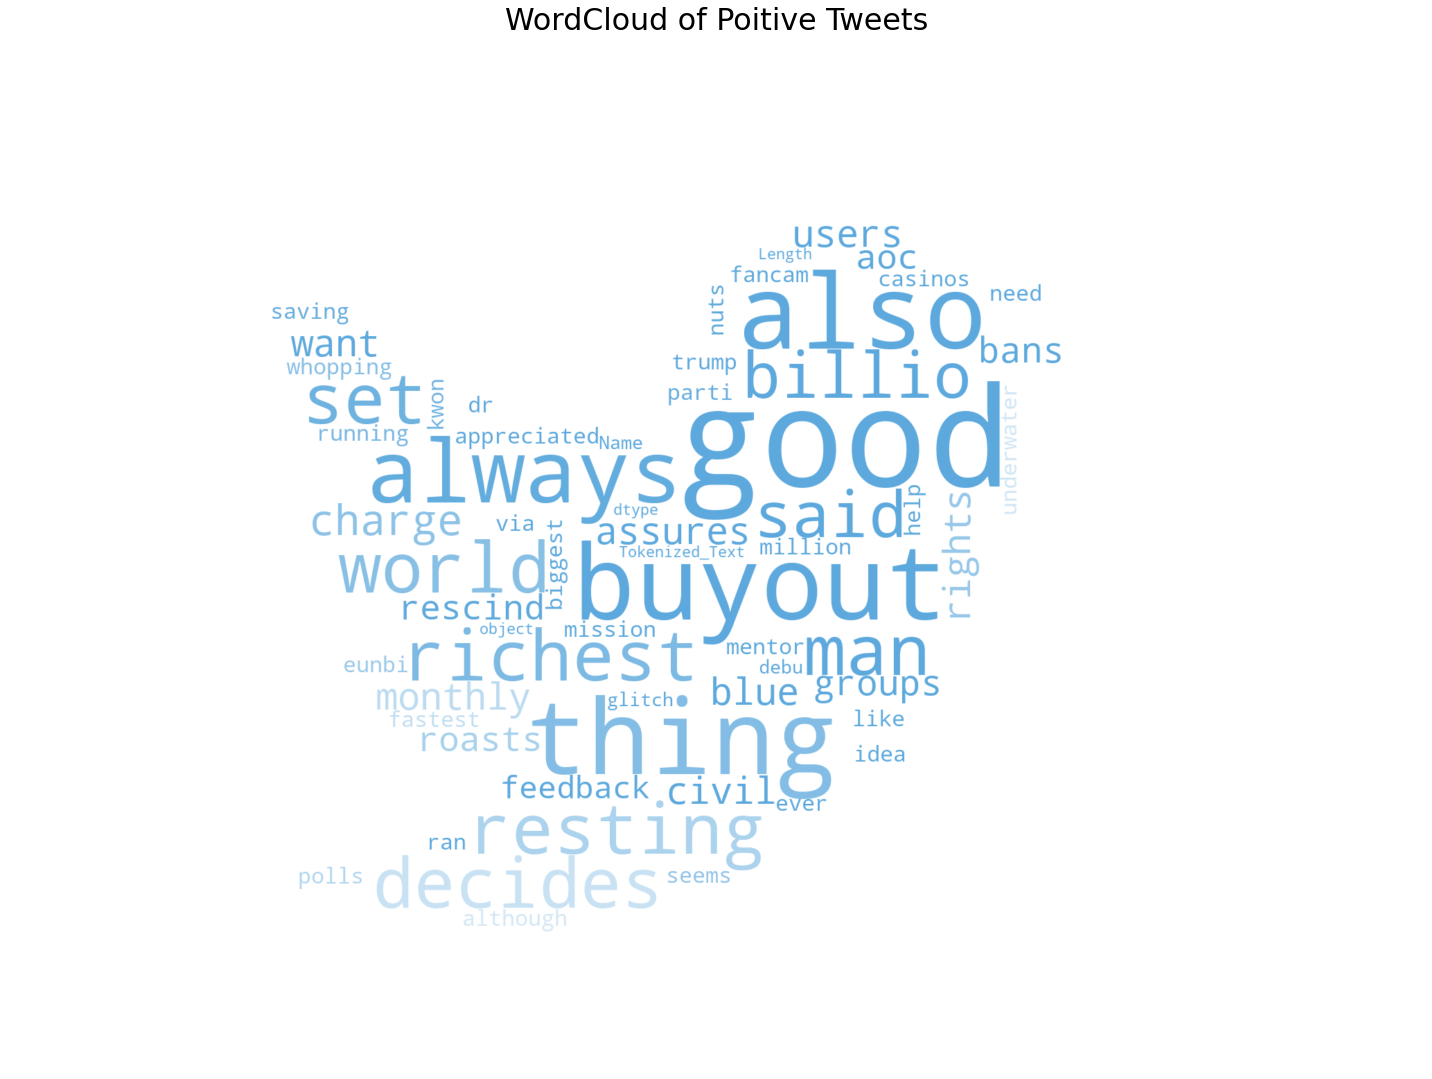

In [42]:
#word Cloud of Positive words
mask = np.array(Image.open('/Users/milad/Downloads/logo.jpg'))
plot_wordcloud(Positive_sent['Tokenized_Text'],mask = mask, color='white',max_font_size=200,title_size=30,title="WordCloud of Poitive Tweets", image_color=True)

In [39]:
#MosT common Negative words
from collections import Counter

top = Counter([item for sublist in Negative_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,employees,1571
1,layoffs,1252
2,staff,1029
3,via,908
4,fired,905
5,people,904
6,advertisers,748
7,company,743
8,new,733
9,half,707


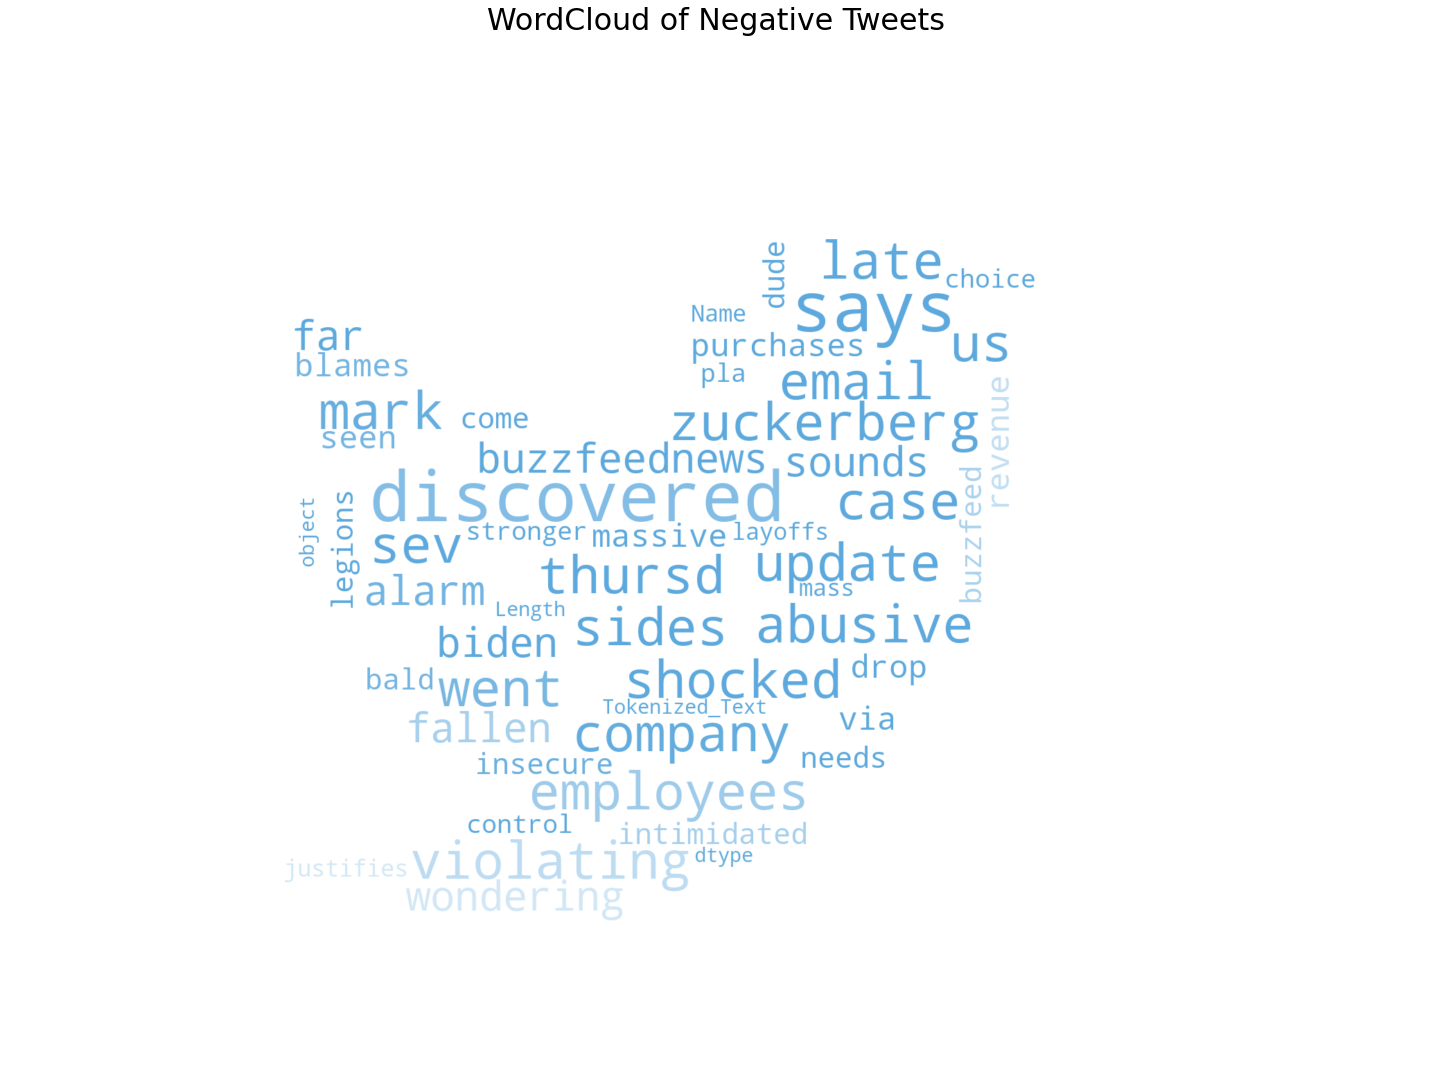

In [43]:
#Wordcloud of Negative words
mask = np.array(Image.open('/Users/milad/Downloads/logo.jpg'))
plot_wordcloud(Negative_sent['Tokenized_Text'],color='white',mask=mask,max_font_size=100,title_size=30,title="WordCloud of Negative Tweets", image_color=True)

In [44]:
#MosT common Neutral words
from collections import Counter

top = Counter([item for sublist in Neutral_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,layoffs,2018
1,mass,1140
2,employees,916
3,musks,893
4,begin,752
5,staff,741
6,takeover,676
7,via,657
8,friday,486
9,begins,480


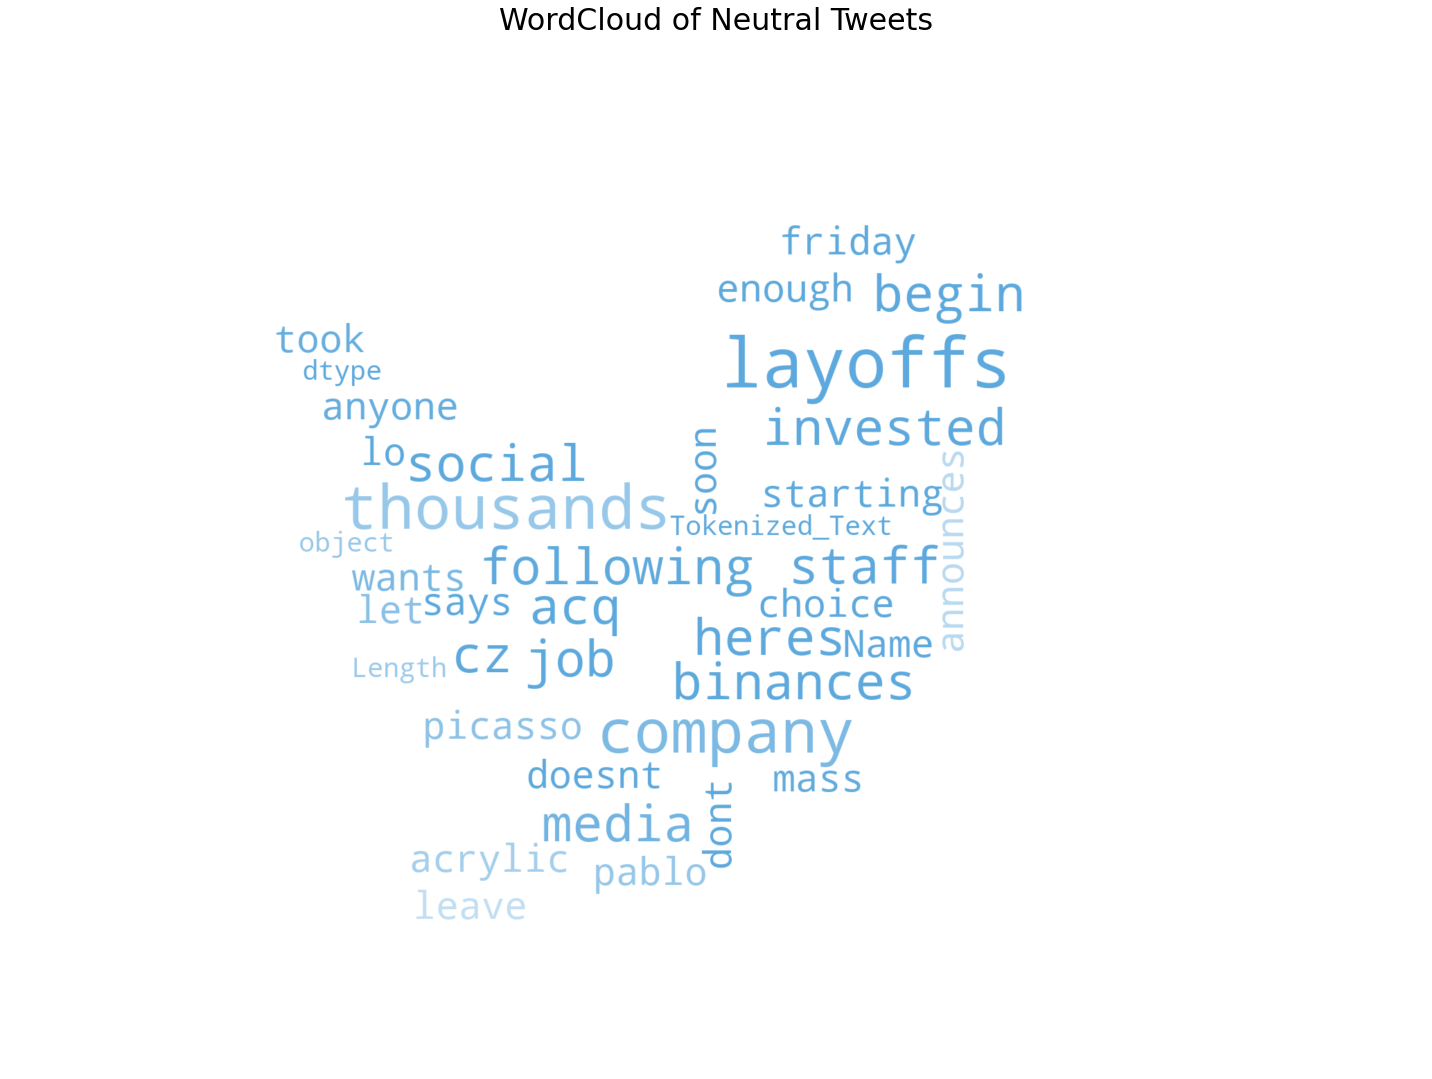

In [45]:
#WordCloud of Neutral tweets
mask = np.array(Image.open('/Users/milad/Downloads/logo.jpg'))
plot_wordcloud(Neutral_sent['Tokenized_Text'],color='white',mask=mask,max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets", image_color=True)

In [46]:
#getting the length of each tweet to see the relationship between length and sentiment
tweets_raw['length'] = tweets_raw.text.str.split().apply(len)
tweets_raw

,text,Sentiment,Cleaned_Text,Tokenized_Text,length
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,took anyone doesnt want leave dont let door hi...,"[took, anyone, doesnt, wants, leave, dont, let...",21
1,Why is this Twitter buyout a good thing again?...,Positive,buyout good thing also always resting smug fac...,"[buyout, good, thing, also, always, resting, s...",26
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,layoff starting,"[layoffs, starting]",7
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,shocked,[shocked],6
4,«An email went out to the company’s employees ...,Negative,email went company employee late thursday noti...,"[email, went, company, employees, late, thursd...",42
...,...,...,...,...,...
30330,'No choice': Elon Musk justifies mass layoffs ...,Negative,choice justifies mass layoff,"[choice, justifies, mass, layoffs]",10
30331,Here's why Binance's CZ invested in Twitter fo...,Neutral,here binances cz invested following acquisitio...,"[heres, binances, cz, invested, following, acq...",14
30332,Elon Musk says Twitter had ‘no choice’ over th...,Neutral,say choice thousand layoff company losing per day,"[says, choice, thousands, layoffs, company, lo...",19
30333,Thousands of staff at social media company Twi...,Neutral,thousand staff social medium company job new o...,"[thousands, staff, social, media, company, job...",44


Text(12.5, 0.0008, 'Median : 14')

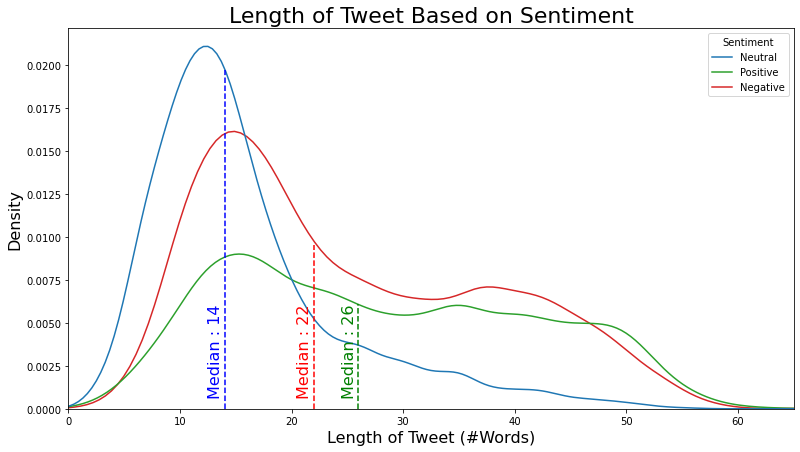

In [47]:
#fig, ax = plt.subplots(figsize=(20, 16))
palette = ['tab:blue', 'tab:green','tab:red']
fig, ax = plt.subplots(figsize=(13, 7))
sns.kdeplot(data=tweets_raw,x='length', hue='Sentiment' , palette=palette)
plt.xlim(0, 65)
ax.set_xlabel('Length of Tweet (#Words)', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title('Length of Tweet Based on Sentiment', fontsize=22)

plt.axvline(x=(tweets_raw.length[tweets_raw.Sentiment=='Positive']).median(),
            ymax=0.275,ls='--',color='green')
tx_p = "Median : {:.0f}".format((tweets_raw.length[tweets_raw.Sentiment=='Positive']).median())
plt.text((tweets_raw.length[tweets_raw.Sentiment=='Positive']).median()-1.5,0.0008,tx_p, rotation =90, color='green',  fontsize=16)

plt.axvline(x=(tweets_raw.length[tweets_raw.Sentiment=='Negative']).median(),
            ymax=0.43,ls='--',color='red')
tx_n = "Median : {:.0f}".format((tweets_raw.length[tweets_raw.Sentiment=='Negative']).median())
plt.text((tweets_raw.length[tweets_raw.Sentiment=='Negative']).median()-1.5,0.0008,tx_n, rotation =90, color='red',  fontsize=16)

plt.axvline(x=(tweets_raw.length[tweets_raw.Sentiment=='Neutral']).median(),
            ymax=0.89,ls='--',color='blue')
tx_nu = "Median : {:.0f}".format((tweets_raw.length[tweets_raw.Sentiment=='Neutral']).median())
plt.text((tweets_raw.length[tweets_raw.Sentiment=='Neutral']).median()-1.5,0.0008,tx_nu, rotation =90, color='blue',  fontsize=16)

# Train-Test Split

In this Section, I split the data to test set and training set. using random state to get the same result everytime running this notebook. 
Also using 20% as the test size.

In [48]:
#Adding another set of train_test split for Neural Network modeling
X=tweets_raw.Cleaned_Text
y=tweets_raw.Sentiment
y_NN=pd.get_dummies(tweets_raw.Sentiment)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y_NN, test_size=0.2, random_state=42)

# Baseline Model

In this Section I created dummy variables for my target(sentiment) value to get the accuracy of random prediction of sentiment. This should be serve as a baseline model and the goal is getting better results than random prediction.

In [49]:
cv_dict = {}
def reportcrossval(model, model_name, X, Y):
    cv_mean = cross_val_score(model, X, Y).mean()
    cv_dict[model_name] = cv_mean
    print(f"The cv mean of {model_name} is {cv_mean}")

In [50]:
pipe_dummy = Pipeline([('dummy', DummyClassifier(strategy='most_frequent'))], verbose=True)

In [51]:
reportcrossval(pipe_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.39776660009470016


So, the baseline model has a score(accuracy) of about 40%, meaning random prediction is right 40% of the time. let's beat it.

# Modeling

In the first part of modeling section, I defined some functions to get the metrics of validation set, results of training and test set, and plotting the confusion matrix.

In [52]:
def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')

In [53]:
def display_prediction_results(prediction, actuall, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(actuall,prediction)
    recall = recall_score(actuall, prediction, average = 'micro')
    precision = precision_score(actuall, prediction, average = 'micro')
#    roc_auc_score = roc_auc_score(actuall, prediction,  average = 'micro')

    print('='*60)
    print(f'Predictions for: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
#    print(f'Roc_AUC Score: {roc_auc_score}\n')

In [54]:
def display_confusion_matrix_v2(actuall_y,predicted_y,model_name):
    conf_matrix = confusion_matrix(y_true=actuall_y, y_pred=predicted_y, cmap=plt.cm.Blues)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, alpha=0.3)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title(f'Confusion Matrix for {model_name}');
    save_image_as = 'confusion_matrix_' + '_'.join(model_name.split()) + ': ' 
    fig.savefig(save_image_as)
    

In [55]:
def display_confusion_matrix(model, X, y, model_name):
    print(f'Confusion Matrix for Model: {model_name}')
    plot_confusion_matrix(model,X,y, cmap=plt.cm.Blues)
    print('='*80)
    

Throughtout this project, I used 2 vectorizer; TF_IDF and Count vectorizer along with some classifires.

### TF_IDF Vectorizer

TF_IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

I also used gridsearching for each model and vectorizer I tried to get the best hyperparameters. Then modified the model based on the best parameters.

In [57]:
# MultinomialNB
# Use pipes to TF_IDF Vectorize X_train and then train MultinomialNB

TF_mnb_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_mnb_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1)], #n_grams of 1,2, and 3 tested
                 'mnb__alpha' : [1.0]} #0 and 1 tested.

TF_mnb_model_grid = GridSearchCV(estimator = TF_mnb_pipe, param_grid = TF_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_mnb_model_grid.fit(X_train,y_train)
display(TF_mnb_model_grid.best_score_)
display(TF_mnb_model_grid.best_params_)

0.7138206917490411

{'mnb__alpha': 1.0,
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 1)}

In [58]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(TF_mnb_model_grid.cv_results_,model_name)

y_hat_TF_MNB = TF_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_MNB, y_test,model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.7138206917490411
Recall: 0.7138206917490411
Precision: 0.7138206917490411

Predictions for: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.7301796604582166
Recall: 0.7301796604582166
Precision: 0.7301796604582166


Confusion Matrix for Model: MultinomialNB with TF-IDF Vectorize


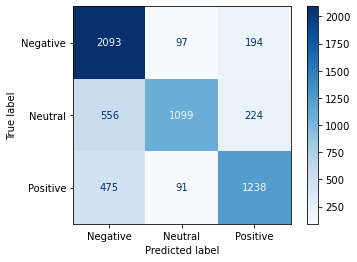

In [59]:
display_confusion_matrix(TF_mnb_model_grid, X_test,
                         y_test,model_name)

In [ ]:
results_df = pd.DataFrame(y_test)
results_df['tweet_text'] = X_test
y_pred_proba = TF_mnb_model_grid.predict_proba(X_test)
y_pred_proba = pd.DataFrame(data = y_pred_proba, columns = ['pred_NG','pred_NU','pred_PS'])
results_df.insert(loc = 2, column = 'pred_NG' , value = y_pred_proba['pred_NG'].values)
results_df.insert(loc = 3, column = 'pred_NU' , value = y_pred_proba['pred_NU'].values)
results_df.insert(loc = 4, column = 'pred_PS' , value = y_pred_proba['pred_PS'].values)
results_df.insert(loc = 5, column = 'pred' , value = y_hat_TF_MNB)

In [ ]:
results_df

In [ ]:
errors_df = results_df[results_df['Sentiment'] != results_df['pred']]
errors_df

In [ ]:
false_neg_df = errors_df[errors_df['Sentiment'] == 'Positive']
false_neg_df_sort = false_neg_df.sort_values(by = 'pred_PS')

false_neg_df_sort

In [ ]:
most_confident_false_neg = false_neg_df_sort.iloc[0:6].tweet_text.values

most_confident_false_neg

In [61]:
# LogisticRegression
# Use pipes to TF_IDF Vectorize X_train and then train LogisticRegression

TF_LR_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_LR_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 2)], #n_grams of 1,2, and 3 tested
                 'lr__penalty' : ['l1'], #L1 and L2 tested
                'lr__C' : [100],  # tried 1 and 100
                'lr__class_weight' : [None],  # tried None and 'balanced'
                'lr__solver' : ['liblinear'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [1000],
                'lr__multi_class' : ['auto']} # auto and multinomial class tested

TF_LR_model_grid = GridSearchCV(estimator = TF_LR_pipe, param_grid = TF_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_LR_model_grid.fit(X_train,y_train)
display(TF_LR_model_grid.best_score_)
display(TF_LR_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.8495554638043693

{'lr__C': 100,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__multi_class': 'auto',
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear',
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 2)}

In [62]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with TF-IDF Vectorize'

display_cross_validation_results(TF_LR_model_grid.cv_results_,model_name)

y_hat_TF_LR = TF_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_LR, y_test,model_name)


Validation ============================================================
Validation results for Logistic Regression with TF-IDF Vectorize:
Accuracy: 0.8092964215084593
Recall: 0.8092964215084593
Precision: 0.8092964215084593

Predictions for: Logistic Regression with TF-IDF Vectorize
Accuracy: 0.8646777649579693
Recall: 0.8646777649579693
Precision: 0.8646777649579693


Confusion Matrix for Model: Logistic Regression with TF-IDF Vectorize


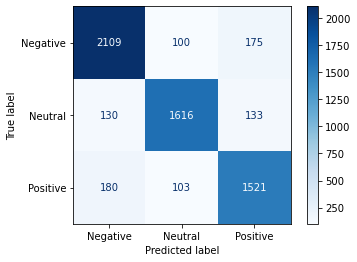

In [63]:
display_confusion_matrix(TF_LR_model_grid, X_test,
                         y_test,model_name)

In [64]:
# Decision Tree 
# Use pipes to TF_IDF Vectorize X_train and then train Decision Tree

TF_DT_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('DT', DecisionTreeClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_DT_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 2)],#n_grams of 1,2, and 3 tested
                 'DT__max_depth': [30], # max depth of 10, 20, 30 tested
                 'DT__min_samples_split': [6], # min sample split of 6, 10 , 15 tested
                 'DT__criterion': ['gini']} # gini and entropy tested

TF_DT_model_grid = GridSearchCV(estimator = TF_DT_pipe, param_grid = TF_DT_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_DT_model_grid.fit(X_train,y_train)
display(TF_DT_model_grid.best_score_)
display(TF_DT_model_grid.best_params_)

0.5924264008746304

{'DT__criterion': 'gini',
 'DT__max_depth': 30,
 'DT__min_samples_split': 6,
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 2)}

In [65]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Decision Tree with TF-IDF Vectorize'

display_cross_validation_results(TF_DT_model_grid.cv_results_,model_name)

y_hat_TF_DT = TF_DT_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_DT, y_test,model_name)

Validation ============================================================
Validation results for Decision Tree with TF-IDF Vectorize:
Accuracy: 0.5509312052039054
Recall: 0.5509312052039054
Precision: 0.5509312052039054

Predictions for: Decision Tree with TF-IDF Vectorize
Accuracy: 0.5930443382231746
Recall: 0.5930443382231746
Precision: 0.5930443382231746


Confusion Matrix for Model: Decision Tree with TF-IDF Vectorize


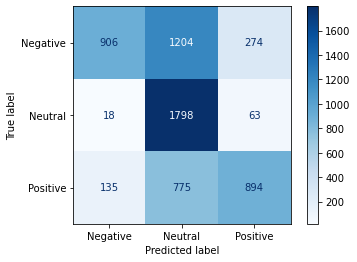

In [66]:
display_confusion_matrix(TF_DT_model_grid, X_test,
                         y_test,model_name)

In [67]:
# RandomForest 
# Use pipes to CountVectorize X_train and then train RandomForest Classifier

TF_RF_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('RF', RandomForestClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_RF_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1)], #n_grams of 1,2, and 3 tested
                 'RF__n_estimators': [500], #number of estimators of 100 and 500 tested
                 'RF__max_depth': [30], #max depth of 10,20 and 30 tested
                 'RF__min_samples_split': [6,10], # 10 and 15 tested
                 'RF__criterion': ['gini'] # gini and entropy tested
}

TF_RF_model_grid = GridSearchCV(estimator = TF_RF_pipe, param_grid = TF_RF_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_RF_model_grid.fit(X_train,y_train)
display(TF_RF_model_grid.best_score_)
display(TF_RF_model_grid.best_params_)

0.7316630400609396

{'RF__criterion': 'gini',
 'RF__max_depth': 30,
 'RF__min_samples_split': 6,
 'RF__n_estimators': 500,
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 1)}

In [70]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Random Forest with TF-IDF Vectorize'

display_cross_validation_results(TF_DT_model_grid.cv_results_,model_name)

y_hat_TF_RF = TF_RF_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_RF, y_test,model_name)

Validation ============================================================
Validation results for Random Forest with TF-IDF Vectorize:
Accuracy: 0.5509312052039054
Recall: 0.5509312052039054
Precision: 0.5509312052039054

Predictions for: Random Forest with TF-IDF Vectorize
Accuracy: 0.7354540959287951
Recall: 0.7354540959287951
Precision: 0.7354540959287951






As we can see, This model is overfitted. for now I ignore it to see if I can better results with other classifiers.

Confusion Matrix for Model: Random Forest with TF-IDF Vectorize


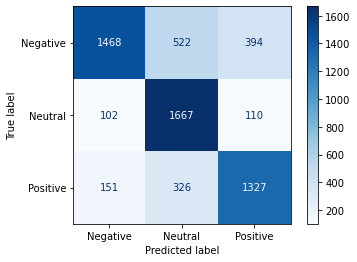

In [69]:
display_confusion_matrix(TF_RF_model_grid, X_test,
                         y_test,model_name)

In [71]:
# KNearest Neighbor
# Use pipes to CountVectorize X_train and then train KNearest Neighbor

TF_KNN_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('knn', KNeighborsClassifier())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_KNN_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1)],
                 'knn__n_neighbors' : [3],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [3]}  #tried 3,15,30,45  # tried None and 'balanced'

TF_KNN_model_grid = GridSearchCV(estimator = TF_KNN_pipe, param_grid = TF_KNN_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_KNN_model_grid.fit(X_train,y_train)
display(TF_KNN_model_grid.best_score_)
display(TF_KNN_model_grid.best_params_)

0.5651476864395001

{'knn__leaf_size': 3,
 'knn__n_neighbors': 3,
 'knn__weights': 'distance',
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 1)}

In [72]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'K_Nearest Neighbor with TF-IDF Vectorize'

display_cross_validation_results(TF_KNN_model_grid.cv_results_,model_name)

y_hat_TF_KNN = TF_RF_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_KNN, y_test,model_name)

Validation ============================================================
Validation results for K_Nearest Neighbor with TF-IDF Vectorize:
Accuracy: 0.5651476864395001
Recall: 0.5651476864395001
Precision: 0.5651476864395001

Predictions for: K_Nearest Neighbor with TF-IDF Vectorize
Accuracy: 0.7354540959287951
Recall: 0.7354540959287951
Precision: 0.7354540959287951


Confusion Matrix for Model: K_Nearest Neighbor with TF-IDF Vectorize


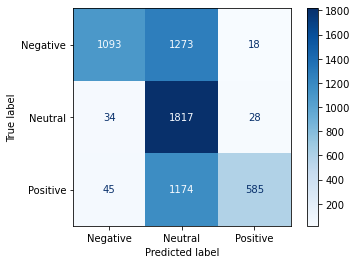

In [73]:
display_confusion_matrix(TF_KNN_model_grid, X_test,
                         y_test,model_name)

# Count Vectorizer

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).

In [74]:
# MultinomialNB
# Use pipes to Count Vectorize X_train and then train MultinomialNB


CT_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_mnb_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 3)],
                 'mnb__alpha' : [1.0]}

CT_mnb_model_grid = GridSearchCV(estimator = CT_mnb_pipe, param_grid = CT_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_mnb_model_grid.fit(X_train,y_train)
display(CT_mnb_model_grid.best_score_)
display(CT_mnb_model_grid.best_params_)

0.7265948426380838

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 3),
 'mnb__alpha': 1.0}

In [75]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(CT_mnb_model_grid.cv_results_,model_name)

y_hat_CT_MNB = CT_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_MNB, y_test,model_name)

Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.7108949807488069
Recall: 0.7108949807488069
Precision: 0.7108949807488069

Predictions for: MultinomialNB with Count Vectorize
Accuracy: 0.7389154442063622
Recall: 0.7389154442063622
Precision: 0.7389154442063622


Confusion Matrix for Model: MultinomialNB with Count Vectorize


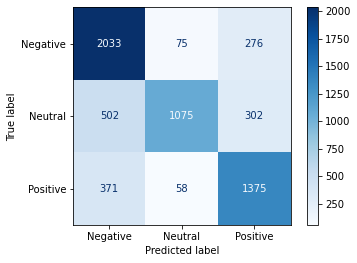

In [76]:
display_confusion_matrix(CT_mnb_model_grid, X_test,
                         y_test,model_name)

In [77]:
# LogisticRegression
# Use pipes to Count_Vectorizer Vectorize X_train and then train LogisticRegression

CT_LR_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_LR_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 2)], # n-grams of 1, 2, and 3 tested
                 'lr__penalty' : ['l1'],
                'lr__C' : [ 100],  # tried 1 and 1000
                'lr__class_weight' : ['balanced'],  # tried None and 'balanced'
                'lr__solver' : ['liblinear'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [1000]} # treid 100,1000 and 10000

CT_LR_model_grid = GridSearchCV(estimator = CT_LR_pipe, param_grid = CT_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_LR_model_grid.fit(X_train,y_train)
display(CT_LR_model_grid.best_score_)
display(CT_LR_model_grid.best_params_)

0.86154638162556

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 2),
 'lr__C': 100,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 1000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [78]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with Count Vectorize'

display_cross_validation_results(CT_LR_model_grid.cv_results_,model_name)

y_hat_CT_LR = CT_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_LR, y_test,model_name)

Validation ============================================================
Validation results for Logistic Regression with Count Vectorize:
Accuracy: 0.8179501998220277
Recall: 0.8179501998220277
Precision: 0.8179501998220277

Predictions for: Logistic Regression with Count Vectorize
Accuracy: 0.8735783748145707
Recall: 0.8735783748145707
Precision: 0.8735783748145707


Confusion Matrix for Model: Logistic Regression with Count Vectorize


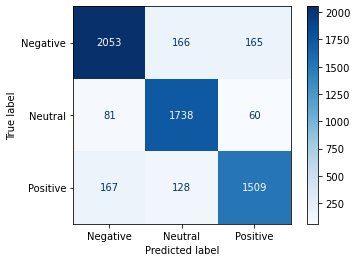

In [79]:
display_confusion_matrix(CT_LR_model_grid, X_test,
                         y_test,model_name)

In [80]:
# KNearest Neighbor
# Use pipes to CountVectorize X_train and then train KNearest Neighbor

CT_KNN_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('knn', KNeighborsClassifier())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_KNN_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1)],
                 'knn__n_neighbors' : [3],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [3]}  #tried 3,15,30,45  # tried None and 'balanced'

CT_KNN_model_grid = GridSearchCV(estimator = CT_KNN_pipe, param_grid = CT_KNN_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_KNN_model_grid.fit(X_train,y_train)
display(CT_KNN_model_grid.best_score_)
display(CT_KNN_model_grid.best_params_)


0.6432749111475229

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 1),
 'knn__leaf_size': 3,
 'knn__n_neighbors': 3,
 'knn__weights': 'distance'}

In [81]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'K_Nearest Neighbor with Count Vectorize'

display_cross_validation_results(CT_KNN_model_grid.cv_results_,model_name)

y_hat_CT_KNN = CT_KNN_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_KNN, y_test,model_name)

Validation ============================================================
Validation results for K_Nearest Neighbor with Count Vectorize:
Accuracy: 0.6432749111475229
Recall: 0.6432749111475229
Precision: 0.6432749111475229

Predictions for: K_Nearest Neighbor with Count Vectorize
Accuracy: 0.6502389978572606
Recall: 0.6502389978572606
Precision: 0.6502389978572606


Confusion Matrix for Model: K_Nearest Neighbor with Count Vectorize


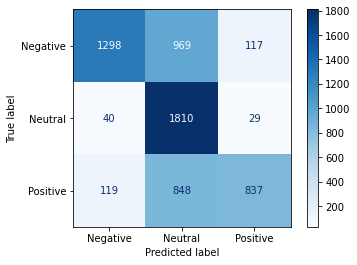

In [82]:
display_confusion_matrix(CT_KNN_model_grid, X_test,
                         y_test,model_name)

In [83]:
# Decision Tree 
# Use pipes to CountVectorize X_train and then train Decision Tree

CT_DT_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('DT', DecisionTreeClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_DT_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 2)],
                 'DT__max_depth': [30],
                 'DT__min_samples_split': [6],
                 'DT__criterion': ['gini']}

CT_DT_model_grid = GridSearchCV(estimator = CT_DT_pipe, param_grid = CT_DT_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_DT_model_grid.fit(X_train,y_train)
display(CT_DT_model_grid.best_score_)
display(CT_DT_model_grid.best_params_)

0.604293598928396

{'DT__criterion': 'gini',
 'DT__max_depth': 30,
 'DT__min_samples_split': 6,
 'countvect__input': 'content',
 'countvect__ngram_range': (1, 2)}

In [84]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Decision Tree with Count Vectorize'

display_cross_validation_results(CT_DT_model_grid.cv_results_,model_name)

y_hat_CT_DT = CT_DT_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_DT, y_test,model_name)

Validation ============================================================
Validation results for Decision Tree with Count Vectorize:
Accuracy: 0.5672491140647522
Recall: 0.5672491140647522
Precision: 0.5672491140647522

Predictions for: Decision Tree with Count Vectorize
Accuracy: 0.605406296357343
Recall: 0.605406296357343
Precision: 0.605406296357343


Confusion Matrix for Model: Decision Tree with Count Vectorize


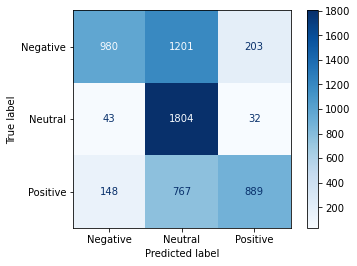

In [85]:
display_confusion_matrix(CT_DT_model_grid, X_test,
                         y_test,model_name)

In [86]:
# RandomForest 
# Use pipes to CountVectorize X_train and then train RandomForest Classifier

CT_RF_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('RF', RandomForestClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_RF_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1)],
                 'RF__n_estimators': [500],
                 'RF__max_depth': [50],
                 'RF__min_samples_split': [10],
                 'RF__criterion': ['entropy']
}

CT_RF_model_grid = GridSearchCV(estimator = CT_RF_pipe, param_grid = CT_RF_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_RF_model_grid.fit(X_train,y_train)
display(CT_RF_model_grid.best_score_)
display(CT_RF_model_grid.best_params_)

0.7447668414722042

{'RF__criterion': 'entropy',
 'RF__max_depth': 50,
 'RF__min_samples_split': 10,
 'RF__n_estimators': 500,
 'countvect__input': 'content',
 'countvect__ngram_range': (1, 1)}

In [87]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'RandomForest with Count Vectorize'

display_cross_validation_results(CT_RF_model_grid.cv_results_,model_name)

y_hat_CT_RF = CT_RF_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_RF, y_test,model_name)

Validation ============================================================
Validation results for RandomForest with Count Vectorize:
Accuracy: 0.6889724017129567
Recall: 0.6889724017129567
Precision: 0.6889724017129567

Predictions for: RandomForest with Count Vectorize
Accuracy: 0.7562221855941981
Recall: 0.7562221855941981
Precision: 0.7562221855941981


Confusion Matrix for Model: RandomForest with Count Vectorize


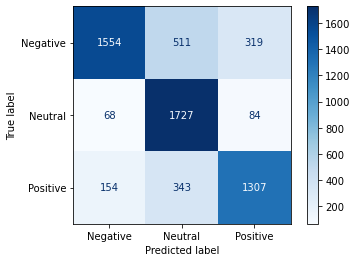

In [88]:
display_confusion_matrix(CT_RF_model_grid, X_test,
                         y_test,model_name)

In [ ]:
# SVC 
# Use pipes to CountVectorize X_train and then train SVC

CT_SVC_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('svc', SVC(random_state = 42))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_SVC_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'svc__kernel' : ['rbf','poly'], # tried 'poly','rbf', 'sigmoid'
                 'svc__degree' : [3,4,5], # tried 3,4,5
                 'svc__C' : [1.0,100],  # tried 1 and 1000
                 'svc__class_weight' : [None,'balanced']} # tried None and 'balanced

CT_SVC_model_grid = GridSearchCV(estimator = CT_SVC_pipe, param_grid = CT_SVC_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_SVC_model_grid.fit(X_train,y_train)
display(CT_SVC_model_grid.best_score_)
display(CT_SVC_model_grid.best_params_)

In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'SVC with Count Vectorize'

display_cross_validation_results(CT_SVC_model_grid.cv_results_,model_name)

y_hat_CT_SVC = CT_SVC_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_SVC, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_SVC_model_grid, X_test,
                         y_test,model_name)

In [ ]:
#!pip install fastapi

In [ ]:
#!pip install uvicorn

# Deployement

So Far, I test some classifiers and couple vectorizers. My best model was Logistic Regression with Count vectorizer and with the test accuracy of 87%. So, I am going to save that model as my best model.
I also save the deployement model in another notebook using Uvicorn which you can test it out.

In [89]:
#Saving the Best Models
import joblib 
joblib.dump(CT_LR_model_grid, 'Models/sentiment_model_pipeline.pkl')

['Models/sentiment_model_pipeline.pkl']

In [90]:
# text preprocessing modules
from string import punctuation
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re  # regular expression
import os
from os.path import dirname, join, realpath
import joblib
import uvicorn
from fastapi import FastAPI 

app = FastAPI(
    title="Sentiment Model API",
    description="A simple API that use NLP model to predict the sentiment of the movie's reviews",
    version="0.1",
)

# load the sentiment model
with open(
    join(dirname(realpath('__file__')), "Models/sentiment_model_pipeline.pkl"), "rb"
) as f:
    model = joblib.load(f)


# cleaning the data
Extended_Stop_Words = stopwords.words('english')
Extended_Stop_Words.extend(['elon','musk','twitter'])
    
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower() # lower case the text
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
    temp = re.sub('[0-9]+', '', temp)
    temp = re.sub(r'http\S+', '', temp) # removes URL's
    temp = re.sub('[()!?]', ' ', temp) # removes special charecters
    temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split() # splitting the words
    
    lemmatizer = WordNetLemmatizer()
    temp = [lemmatizer.lemmatize(w) for w in temp if not w in Extended_Stop_Words] # Removes the stop words and Lemming
    temp = " ".join(word for word in temp) # join all words together
    return temp

@app.get("/predict-review")
def predict_sentiment(review: str):
    """
    A simple function that receive a review content and predict the sentiment of the content.
    :param review:
    :return: prediction, probabilities
    """
    # clean the review
    cleaned_review = text_cleaning(review)
    
    # perform prediction
    prediction = model.predict([cleaned_review])
    output = int(prediction[0])
    probas = model.predict_proba([cleaned_review])
    output_probability = "{:.2f}".format(float(probas[:, output]))
    
    # output dictionary
    sentiments = {0: "Negative", 1: "Positive"}
    
    # show results
    result = {"prediction": sentiments[output], "Probability": output_probability}
    return result

In [91]:
import pickle
from sklearn import model_selection

filename = 'Models/Snetiment_Analysis_Model.sav'
pickle.dump(CT_LR_model_grid, open(filename, 'wb'))


In [92]:
def Sentiment(tweet):
    loaded_model = pickle.load(open(filename, 'rb'))
    cleaned_review = clean_tweet(tweet)
    result = loaded_model.predict([cleaned_review])
    print(f'Tweet Sentiment is : {result[0]}')

 Now testing my model on some new tweets to how it is doing.

In [93]:
Sentiment('A twitter employee was fired for knowing more than elon musk! ')


Tweet Sentiment is : Negative


In [94]:
Sentiment('Elon Musk: twitter usage is at all time high lol ')


Tweet Sentiment is : Positive


In [96]:
Sentiment('Elon Musk: What Lesson took you the longest to unlearn? ')


Tweet Sentiment is : Neutral


# Appendix

I also tried Neural Network to predict the sentiment. I used LSTM (Long short-term memory) as my model.
After running the model and playing around with the parameters, the model seems to be ovefitted with the accuracy less than my best classifier model.

In [97]:
#LSTM
voc_size = 5000

onehot_rep = [one_hot(words,voc_size)for words in list(X_train)]
onehot_rep_test = [one_hot(words,voc_size)for words in list(X_test)]

In [98]:
#Padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=32)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=32)

In [99]:
#Converting into numpy array
X_train_EMB = np.array(embedded_docs)
y_train_EMB = np.array(y_train_NN)
X_test_EMB = np.array(embedded_docs_test)
X_train_EMB.shape,y_train_EMB.shape,X_test_EMB.shape

((24268, 32), (24268, 3), (6067, 32))

In [100]:
model = Sequential()
model.add(Embedding(voc_size,64,input_length=128))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(16,kernel_regularizer=regularizers.L1(0.001))))
model.add(Dropout(0.3))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Recall','Precision'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 128, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 5

In [101]:
tf.config.run_functions_eagerly(True)

history = model.fit(X_train_EMB,y_train_EMB,epochs=20,batch_size=128, validation_split = 0.20 , verbose=1)

Epoch 1/20
152/152 [==============================] - 13s 86ms/step - loss: 1.4706 - accuracy: 0.4522 - recall: 0.4609 - precision: 0.4383 - val_loss: 1.0253 - val_accuracy: 0.5836 - val_recall: 0.5589 - val_precision: 0.6072
Epoch 2/20
152/152 [==============================] - 13s 85ms/step - loss: 0.8731 - accuracy: 0.6571 - recall: 0.5816 - precision: 0.6492 - val_loss: 0.7145 - val_accuracy: 0.7462 - val_recall: 0.6751 - val_precision: 0.7866
Epoch 3/20
152/152 [==============================] - 13s 86ms/step - loss: 0.6977 - accuracy: 0.7533 - recall: 0.6409 - precision: 0.7729 - val_loss: 0.6225 - val_accuracy: 0.7843 - val_recall: 0.7293 - val_precision: 0.8177
Epoch 4/20
152/152 [==============================] - 13s 84ms/step - loss: 0.6004 - accuracy: 0.8078 - recall: 0.6868 - precision: 0.8355 - val_loss: 0.5880 - val_accuracy: 0.7983 - val_recall: 0.7468 - val_precision: 0.8233
Epoch 5/20
152/152 [==============================] - 13s 86ms/step - loss: 0.5505 - accuracy: 0

In [102]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test_EMB, y_test_NN, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))


Accuracy  : 0.7940
Precision : 0.7788
Recall    : 0.8099


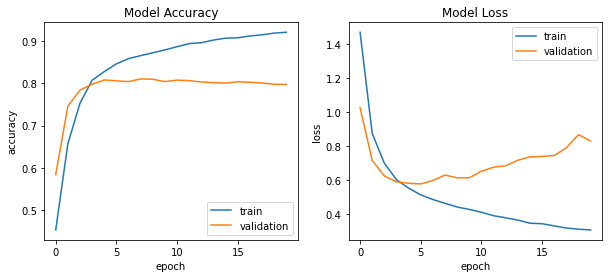

In [103]:
import matplotlib.pyplot as plt
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

As we can see in the graphs above, there is a huge difference between train and validation accuracy and the loss of validation set also started increasing after 5 epochs. this is a clear definitation of ovefitting. I tried lots of methods to overcome the overfitting problem but it was unsuccessfull.